# SVM Model Code

In [20]:
#!pip install tensorflow
#!pip install optree
#!pip install numpy
#!pip install opencv-python
#!pip install h5py
#!pip install hdf5storage
#!pip install matplotlib
#!pip install scipy
#!pip install scikit-learn
#!pip install seaborn

In [21]:
import numpy as np
import os
import cv2
import sys
import h5py
import hdf5storage
import matplotlib.pyplot as plt
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

from scipy.io import loadmat
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import jaccard_score
from sklearn.metrics import classification_report
from tensorflow.keras import backend as K # make sure all K are capital
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# PART I: Load and Pre-process Data

Total files found: 2124
[2120/2124] images loaded: 99.8 %
Finished loading and processing data. Successfully processed 2124/2124 files.


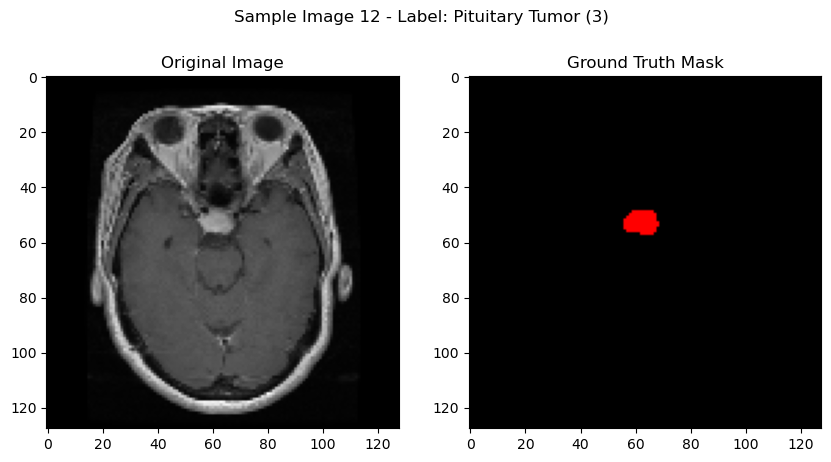

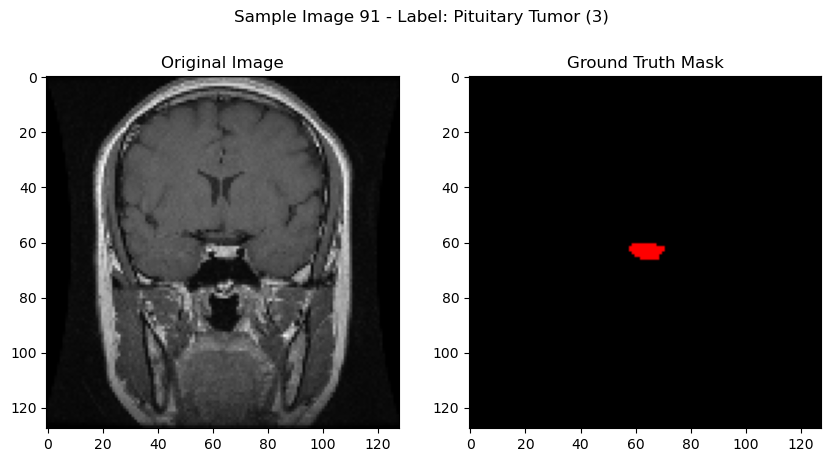

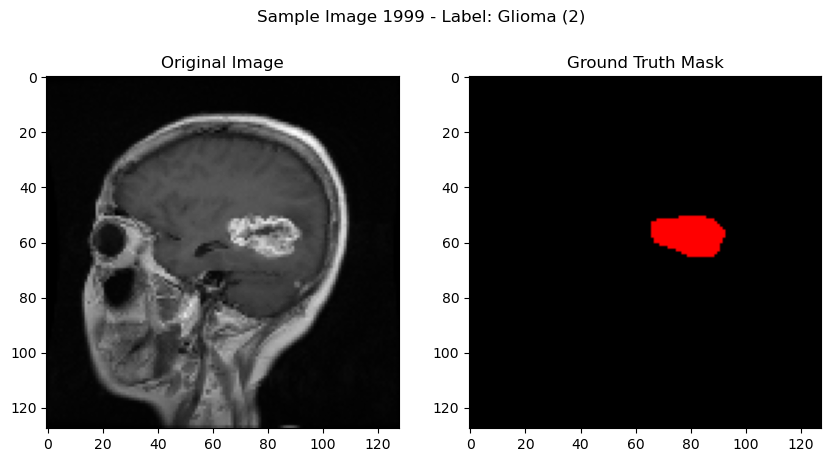

Label 1 (Type): 708 slices, 33.33% of the dataset
Label 3 (Type): 708 slices, 33.33% of the dataset
Label 2 (Type): 708 slices, 33.33% of the dataset
Data type of image: float32
Data type of masks: float32


In [22]:
#data_dir = 'C:/Users/embilab/OneDrive - Emory University/Desktop/Data'
data_dir = 'C:/Users/embilab/OneDrive - Emory University/Spring 2024/CS - 534 Machine Learning/SVM/data_even'
#data_dir  = 'C:/Users/embilab/OneDrive - Emory University/Spring 2024/CS - 534 Machine Learning/SVM/Data' #subset

###Load and preprocess data

def load_and_preprocess_data(data_dir, image_dimension):
    images = []
    masks = []
    labels = []  # Store labels to check distribution
    files = os.listdir(data_dir)
    # Data integrity check
    print(f"Total files found: {len(files)}")
    processed_count = 0
    
    
    for i, file in enumerate(files, start=1):
        try:
            mat_file = hdf5storage.loadmat(os.path.join(data_dir, file))['cjdata'][0] # Load the .mat file
            
            # Resize and normalize the images
            image = mat_file['image']
            image = cv2.resize(image, dsize=(image_dimension, image_dimension), interpolation=cv2.INTER_CUBIC)
            image = image.astype(np.float32) / 255.0  # Scale image to range [0, 1]
            image = np.expand_dims(image, axis=-1)  # Add the channel dimension (fprep or check later)
            
            # Resize and prepare mask for multi-class segmentation
            mask = mat_file['tumorMask'].astype('uint8')
            mask = cv2.resize(mask, dsize=(image_dimension, image_dimension), interpolation=cv2.INTER_NEAREST)
            mask = np.expand_dims(mask, axis=-1)  # Add the channel dimension (prep for check later)
            
            # Get the label and convert to one-hot
            label = int(mat_file['label'])  
            one_hot_mask = np.zeros((image_dimension, image_dimension, 3), dtype=np.float32)  # three classes # set dtype to float32
            for j in range(1, 4):  # labels are 1, 2, 3
                one_hot_mask[:, :, j-1] = (mask[:, :, 0] == j).astype(np.float32)  # Cast to float32
                
            # Append processed image and mask to their respective lists
            images.append(image)
            masks.append(one_hot_mask)
            
            #masks.append(mask)
            labels.append(label)
            processed_count += 1
            if i % 10 == 0:
                sys.stdout.write(f'\r[{i}/{len(files)}] images loaded: {i / float(len(files)) * 100:.1f} %')
                sys.stdout.flush()
        except Exception as e:
            print(f"Failed to process file {file}: {e}")
    print(f"\nFinished loading and processing data. Successfully processed {processed_count}/{len(files)} files.")
    return np.array(images), np.array(masks), np.array(labels)


###Show sample images to double check

def visualize_sample_images(images, masks, labels, num_samples=5):
    """Visual inspection of images and masks, with labels indicating tumor type."""
    # Mapping of label numbers to tumor names
    label_to_tumor = {1: 'Meningioma', 2: 'Glioma', 3: 'Pituitary Tumor'}
    indices = np.random.choice(len(images), num_samples, replace=False)
    for i in indices:
        # Get tumor type from label
        tumor_type = label_to_tumor.get(labels[i], "Unknown Tumor Type")
        title = f"Sample Image {i+1} - Label: {tumor_type} ({labels[i]})"
        show_image_and_mask(images[i], masks[i], title)
        
 #check distribution for tumor types     

def check_data_distribution(labels):
    """Check for class distribution across different tumor types."""
    from collections import Counter
    label_counts = Counter(labels)
    total_counts = len(labels)
    for label, count in label_counts.items():
        print(f"Label {label} (Type): {count} slices, {count / total_counts * 100:.2f}% of the dataset")

        
###display one image and its ground truth mask  

def show_image_and_mask(image, mask, title):
    """Displays an image and its corresponding mask side by side."""
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[1].imshow(mask, cmap='viridis')
    ax[1].set_title('Ground Truth Mask')
    plt.suptitle(title)
    plt.show()
    
###data_dir = '/Users/elizabethnemeti/Desktop/data' # local runs
# data_dir = '/mnt/beegfs/labs/mahmoudilab/nemeti/UNET_tests/data' # cluster runs

image_dimension = 128

# Func to load and preprocess the data
images, masks, labels = load_and_preprocess_data(data_dir, image_dimension)

# Visualization for sample images and masks
visualize_sample_images(images, masks, labels, num_samples=3)

# Check data distribution for class imbalance
check_data_distribution(labels)

# Check data types of masks and predictions to make sure they're both float32

print(f"Data type of image: {images.dtype}")
print(f"Data type of masks: {masks.dtype}")

# Part II: Split data into training and testing 

Here the data is split into training and testing sets and visual as well as dimensionality checks are performed.
The first cell contains the functions that is used to perform the splitting, checks etc. and the following cell calls the function to perform the checks.

In [23]:
#FUNCTIONS
#NEEDED FUNCTIONS FOR LOAD AND PREPROCESS! - DONT TOUCH!!!


def split_data(images, masks, labels, test_size=0.2, val_size=0.25, random_state=42):
    # Split the data into training and testing sets
    images_train_val, images_test, masks_train_val, masks_test, labels_train_val, labels_test = train_test_split(
        images, masks, labels, test_size=test_size, random_state=random_state, stratify=labels)
    
    # Further split into training and validation sets
    images_train, images_val, masks_train, masks_val, labels_train, labels_val = train_test_split(
        images_train_val, masks_train_val, labels_train_val, test_size=val_size/(1-test_size), random_state=random_state)
    
    return images_train, masks_train, labels_train, images_val, masks_val, labels_val, images_test, masks_test, labels_test

def visualize_data_samples(images_train, masks_train, images_val, masks_val, images_test):
    """Display the first image and mask from training, validation, and testing sets."""
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    axes[0].imshow(images_train[0], cmap='gray')
    axes[0].set_title('Training Image')
    axes[1].imshow(masks_train[0], cmap='viridis')
    axes[1].set_title('Training Mask')
    axes[2].imshow(images_val[0], cmap='gray')
    axes[2].set_title('Validation Image')
    axes[3].imshow(masks_val[0], cmap='viridis')
    axes[3].set_title('Validation Mask')
    axes[4].imshow(images_test[0], cmap='gray')
    axes[4].set_title('Testing Image')
    plt.show()
    
#Check distribution

def check_distribution(labels, title="Label distribution"):
    """Print the distribution of labels."""
    unique, counts = np.unique(labels, return_counts=True)
    label_dict = dict(zip(unique, counts))
    print(f"{title}: {label_dict}")

# THIS WORKS DON'T TOUCH!! -----CHECK DIMENSIONS


def check_dimensions(images, masks, required_image_shape, required_mask_shape):
    """
    Validate if the images and masks match the required dimensions.
    - images and masks are the datasets to check.
    - required_image_shape and required_mask_shape are tuples representing the required dimensions.
    """
    # For SVM classification, we don't need masks, so we only check image dimensions
    assert images.shape[1:] == required_image_shape, f"Image shape mismatch: expected {required_image_shape}, got {images.shape[1:]}"
    print(f"Image shape is {images.shape[1:]}")
    print("All images correctly match the required shape.")

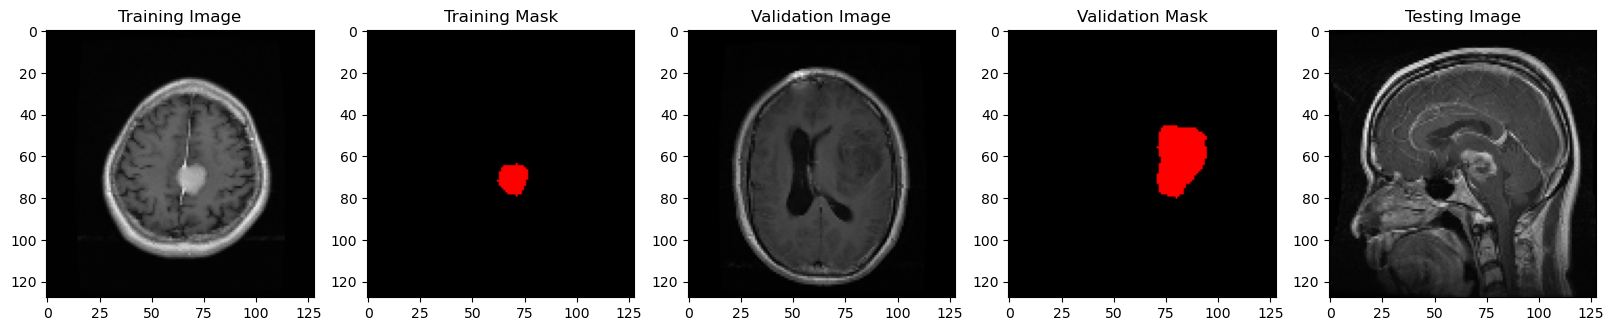

Total Label Distribution: {1: 708, 2: 708, 3: 708}
Training Label Distribution: {1: 399, 2: 388, 3: 381}
Validation Label Distribution: {1: 168, 2: 178, 3: 185}
Testing Label Distribution: {1: 141, 2: 142, 3: 142}
Data type of images_train: float32
Data type of masks_train: float32
Data type of labels_train: int32
Data type of images_val: float32
Data type of masks_val: float32
Data type of labels_val: int32
Data type of images_test: float32
Data type of masks_test: float32
Data type of labels_test: int32
Image shape is (128, 128, 1)
All images correctly match the required shape.


In [24]:
# THIS WORKS - ODN'T TOUCH!!!

# Load and preprocess the data
# Images, masks, labels = load_and_preprocess_data(data_dir, image_dimension)
# Somehow needed to redefine this function that worked fine in the last iterance!!!!

# Split the data into training, validation, and testing sets
images_train, masks_train, labels_train, images_val, masks_val, labels_val, images_test, masks_test, labels_test = split_data(images, masks, labels, test_size=0.2, val_size=0.25, random_state = 42)

# Visualization for the first training, validation, and testing images
visualize_data_samples(images_train, masks_train, images_val, masks_val, images_test)

# Check label distributions
check_distribution(labels, "Total Label Distribution")
check_distribution(labels_train, "Training Label Distribution")
check_distribution(labels_val, "Validation Label Distribution")
check_distribution(labels_test, "Testing Label Distribution")

# DEBUG: Check data types -- see code from Elizabeth
print(f"Data type of images_train: {images_train.dtype}")
print(f"Data type of masks_train: {masks_train.dtype}")
print(f"Data type of labels_train: {labels_train.dtype}")
print(f"Data type of images_val: {images_val.dtype}")
print(f"Data type of masks_val: {masks_val.dtype}")
print(f"Data type of labels_val: {labels_val.dtype}")
print(f"Data type of images_test: {images_test.dtype}")
print(f"Data type of masks_test: {masks_test.dtype}")
print(f"Data type of labels_test: {labels_test.dtype}")

#CHECK IMAGE SHAPES AND DIMENSIONS
# Required shape for SVM
required_image_shape = (image_dimension, image_dimension, 1)  # This is for images, which are grayscale and should have a single channel explicitly.


check_dimensions(images, None, required_image_shape, None)


### Visual Check Functions

In [25]:
#FUNCTION FOR VISUAL CHECK - WAST OF TIME --FOR VISUAL CHECK AT END 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted

class SVMWithVisualCheck(BaseEstimator, ClassifierMixin):
    def __init__(self, model, validation_data, num_samples=3):
        self.model = model
        self.validation_data = validation_data
        self.num_samples = num_samples
    
    def fit(self, X, y):
        self.model.fit(X, y)
        return self
    
    def predict(self, X):
        check_is_fitted(self)
        return self.model.predict(X)
    
    def visualize(self):
        idxs = np.random.choice(len(self.validation_data[0]), self.num_samples, replace=False)
        images, masks = self.validation_data[0][idxs], self.validation_data[1][idxs]
        preds = self.model.predict(images)
        fig, axes = plt.subplots(self.num_samples, 3, figsize=(15, 5 * self.num_samples))
        for i, (img, mask, pred) in enumerate(zip(images, masks, preds)):
            axes[i, 0].imshow(img.reshape(28, 28), cmap='gray')
            axes[i, 0].set_title('Image')
            # Check if mask is a 2D array, if not, skip visualization
            if mask.ndim == 2:
                axes[i, 1].imshow(mask.reshape(28, 28), cmap='gray')
                axes[i, 1].set_title('True Label')
            # Check if pred is a 2D array, if not, skip visualization
            if pred.ndim == 2:
                axes[i, 2].imshow(pred.reshape(28, 28), cmap='gray')
                axes[i, 2].set_title('Predicted Label')
            for ax in axes[i]:
                ax.axis('off')
        plt.tight_layout()
        plt.show()

# Part III: Train and Evaluate Performance of different Kernels on Validation dataset.

In this step hyperparameters are tuned and the model is evaluated across different kernels and the best is chosen and validated on the final model.


In [26]:
#WORKS DONT TOUCH

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, jaccard_score
from sklearn.model_selection import StratifiedKFold


# Define kernel names and evaluation metrics
kernel_names = ['rbf', 'linear', 'sigmoid']
evaluation_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'jaccard_index': [],
    'f1_score': [],
    'specificity': [],
    'dice_similarity': []
}

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

'''
# Debugging: Check dimensions of the data
print("Data Dimensions:")
print(f"Train set: X_train={images_train.shape}, y_train={labels_train.shape}")
print(f"Validation set: X_val={images_val.shape}, y_val={labels_val.shape}")
print(f"Test set: X_test={images_test.shape}, y_test={labels_test.shape}")
'''
# Iterate over each kernel
for kernel in kernel_names:
    print(f"Evaluating SVM with {kernel} kernel...")
    
    # Initialize lists to store evaluation metrics for current kernel
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    jaccard_scores = []
    f1_scores = []
    specificity_scores = []
    dice_scores = []
    
    # Loop over cross-validation folds
    for train_index, val_index in skf.split(images, labels):
        X_train, X_val = images[train_index], images[val_index]
        y_train, y_val = labels[train_index], labels[val_index]
        
        # Initialize SVM model with current kernel
        svm_model = SVC(kernel=kernel, C=1.0, random_state=42)
        
        # Train the SVM model on the training data
        svm_model.fit(X_train.reshape(len(X_train), -1), y_train)
        
        # Make predictions on the validation set
        y_val_pred = svm_model.predict(X_val.reshape(len(X_val), -1))
        
        # Compute evaluation metrics for the validation set
        accuracy = accuracy_score(y_val, y_val_pred)
        precision = precision_score(y_val, y_val_pred, average='weighted')
        recall = recall_score(y_val, y_val_pred, average='weighted')
        jaccard_index = jaccard_score(y_val, y_val_pred, average='weighted')
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        conf_matrix = confusion_matrix(y_val, y_val_pred)
        tn = conf_matrix[0, 0]
        fp = conf_matrix[0, 1:].sum()
        fn = conf_matrix[1:, 0].sum()
        specificity = tn / (tn + fp)
        dice_similarity = 2*(conf_matrix[1,1]) / (2*(conf_matrix[1,1]) + fp +fn)
        
        # Append evaluation metrics to lists
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        jaccard_scores.append(jaccard_index)
        f1_scores.append(f1)
        specificity_scores.append(specificity)
        dice_scores.append(dice_similarity)
    
    # Compute average evaluation metrics for the current kernel
    avg_accuracy = np.mean(accuracy_scores)
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_jaccard = np.mean(jaccard_scores)
    avg_f1 = np.mean(f1_scores)
    avg_specificity = np.mean(specificity_scores)
    avg_dice = np.mean(dice_scores)
    
    # Print average evaluation metrics for the current kernel
    print(f"Average Accuracy :"      , avg_accuracy)
    print(f"Average Precision :"     , avg_precision)
    print(f"Average Recall :"        , avg_recall)
    print(f"Average Jaccard Index :" , avg_jaccard)
    print(f"Average F1 Score :"      , avg_f1)
    print(f"Average Specificity:"    , avg_specificity)
    print(f"Dice Similarity:"        , avg_dice)
    
    
    # Store average evaluation metrics for the current kernel
    evaluation_metrics['accuracy'].append(avg_accuracy)
    evaluation_metrics['precision'].append(avg_precision)
    evaluation_metrics['recall'].append(avg_recall)
    evaluation_metrics['jaccard_index'].append(avg_jaccard)
    evaluation_metrics['f1_score'].append(avg_f1)
    evaluation_metrics['specificity'].append(avg_specificity)
    evaluation_metrics['dice_similarity'].append(avg_dice)

# Determine the best-performing kernel based on a chosen metric (e.g., accuracy)
best_kernel = kernel_names[np.argmax(evaluation_metrics['accuracy'])]
print(f"Best Performing Kernel: {best_kernel} \n")


Evaluating SVM with rbf kernel...
Average Accuracy : 0.8305127635960045
Average Precision : 0.8448952274129968
Average Recall : 0.8305127635960045
Average Jaccard Index : 0.71217461492245
Average F1 Score : 0.8272516790651558
Average Specificity: 0.8602237538707422
Dice Similarity: 0.7374888847211736
Evaluating SVM with linear kernel...
Average Accuracy : 0.8074539400665927
Average Precision : 0.8106941560938349
Average Recall : 0.8074539400665927
Average Jaccard Index : 0.6885388999437747
Average F1 Score : 0.8068357183728194
Average Specificity: 0.7854260313654979
Dice Similarity: 0.7166158276349444
Evaluating SVM with sigmoid kernel...
Average Accuracy : 0.5291997780244173
Average Precision : 0.523982124858428
Average Recall : 0.5291997780244173
Average Jaccard Index : 0.3601972355194357
Average F1 Score : 0.5192822672310885
Average Specificity: 0.4138947158126062
Dice Similarity: 0.4904828281194601
Best Performing Kernel: rbf 



# Visualize Evaluation Metrics Across Kernels Validation Dataset 

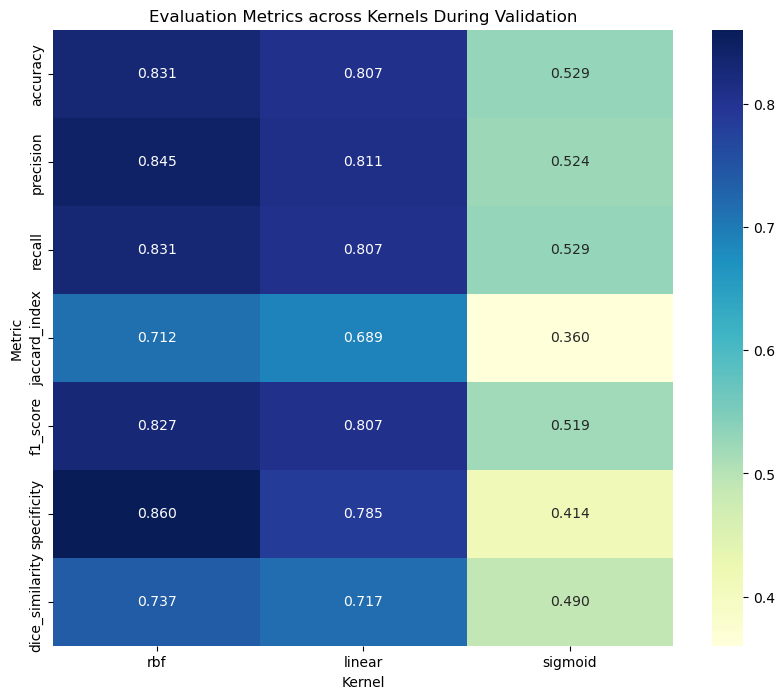

In [27]:
# Create heatmap to visualize all metrics across kernels
import seaborn as sns


# Define the evaluation metric names and their corresponding scores for each kernel
metric_names = ['accuracy', 'precision', 'recall', 'jaccard_index', 'f1_score', 'specificity', 'dice_similarity']
metric_scores = np.array([
    evaluation_metrics['accuracy'],
    evaluation_metrics['precision'],
    evaluation_metrics['recall'],
    evaluation_metrics['jaccard_index'],
    evaluation_metrics['f1_score'],
    evaluation_metrics['specificity'],
    evaluation_metrics['dice_similarity']
])


plt.figure(figsize=(10, 8))
sns.heatmap(metric_scores, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=kernel_names, yticklabels=metric_names)
plt.title('Evaluation Metrics across Kernels During Validation')
plt.xlabel('Kernel')
plt.ylabel('Metric')
plt.show()

#base code referenced: https://www.kaggle.com/code/ashfakyeafi/brain-tumor-type-classification/notebook

# Part IV: Test final model on testing set using best performing Kernel

In [28]:
# Train the final model using the best-performing kernel on the entire dataset
final_svm_model = SVC(kernel=best_kernel, C=1.0, random_state=42)
final_svm_model.fit(images.reshape(len(images), -1), labels)

# Reshape images into feature vectors

num_test_samples = images_test.shape[0]
feature_size = np.prod(images_test.shape[1:])  # Calculate the total number of pixels (features) per image

X_test = images_test.reshape(num_test_samples, feature_size)
y_test = labels_test

# Apply the final model to the test data
final_y_test_pred = final_svm_model.predict(X_test.reshape(len(X_test), -1))

# Compute evaluation metrics on the test set using the final model
final_accuracy = accuracy_score(y_test, final_y_test_pred)
final_precision = precision_score(y_test, final_y_test_pred, average='weighted')
final_recall = recall_score(y_test, final_y_test_pred, average='weighted')
final_jaccard_index = jaccard_score(y_test, final_y_test_pred, average='weighted')
final_f1 = f1_score(y_test, final_y_test_pred, average='weighted')
final_conf_matrix = confusion_matrix(y_test, final_y_test_pred)
final_tn = final_conf_matrix[0, 0]
final_fp = final_conf_matrix[0, 1:].sum()
final_fn = final_conf_matrix[1:, 0].sum()
final_specificity = final_tn / (final_tn + final_fp)
final_dice_similarity = 2 * final_conf_matrix[1, 1] / (2 * final_conf_matrix[1, 1] + final_fp + final_fn)

# Print evaluation metrics for the final model
print("Final Model Evaluation Metrics applied to test set with rbf kernel:")
print(f"Accuracy: {final_accuracy}")
print(f"Precision: {final_precision}")
print(f"Recall: {final_recall}")
print(f"Jaccard Index: {final_jaccard_index}")
print(f"F1 Score: {final_f1}")
print(f"Specificity: {final_specificity}")
print(f"Dice Similarity: {final_dice_similarity}")

Final Model Evaluation Metrics applied to test set:
Accuracy (rbf): 0.9176470588235294
Precision (rbf): 0.926311391830205
Recall (rbf): 0.9176470588235294
Jaccard Index (rbf): 0.8487729088913455
F1 Score (rbf): 0.9167059490765453
Specificity (rbf): 0.9645390070921985
Dice Similarity (rbf): 0.875968992248062


# Visualize Evaluation Metrics Across Kernels Testing Dataset 

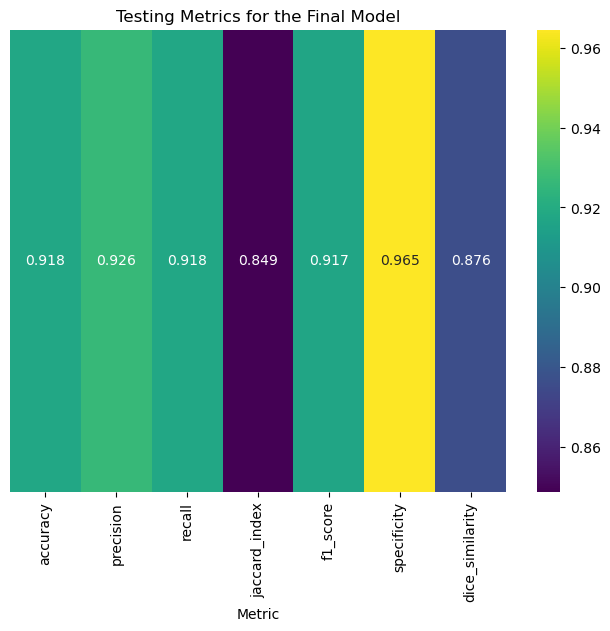

In [29]:
# Define the evaluation metric names and their corresponding scores for each kernel
metric_names = ['accuracy', 'precision', 'recall', 'jaccard_index', 'f1_score', 'specificity', 'dice_similarity']
metric_scores = np.array([
    evaluation_metrics['accuracy'],
    evaluation_metrics['precision'],
    evaluation_metrics['recall'],
    evaluation_metrics['jaccard_index'],
    evaluation_metrics['f1_score'],
    evaluation_metrics['specificity'],
    evaluation_metrics['dice_similarity']
])


# Create a  heatmap for the testing metrics
testing_metric_scores = np.array([
    final_accuracy,
    final_precision,
    final_recall,
    final_jaccard_index,
    final_f1,
    final_specificity,
    final_dice_similarity
    
])

plt.figure(figsize=(8, 6))
sns.heatmap(testing_metric_scores.reshape(1, -1), annot=True, fmt=".3f", cmap="viridis",
            xticklabels=metric_names)
plt.title("Testing Metrics for the Final Model")
plt.xlabel("Metric")
plt.yticks([])   # y axis label snot necessary
plt.show()





# PART V: Visualize Overall Model Performance

## Confusion Matrix- Run from here on test dataset

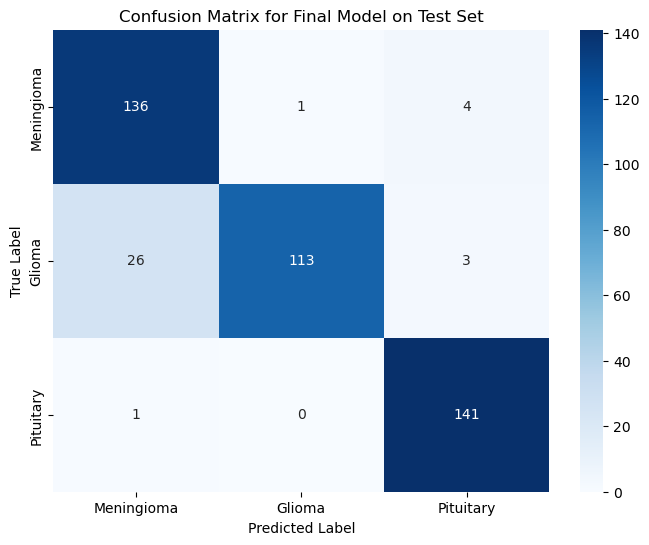

In [30]:
#THIS WORKS, DON'T TOUCH!!!!! - DONT MOVE, KEEP IT RIGHT IN THIS POSITION

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, final_y_test_pred)

# Define Class labels for display
class_labels = ['Meningioma', 'Glioma', 'Pituitary']

# Plot theconfusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels = class_labels, yticklabels = class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Final Model on Test Set")
plt.show()

#Note performance was better on general prediction dataset

## ROC Curve for the dataset

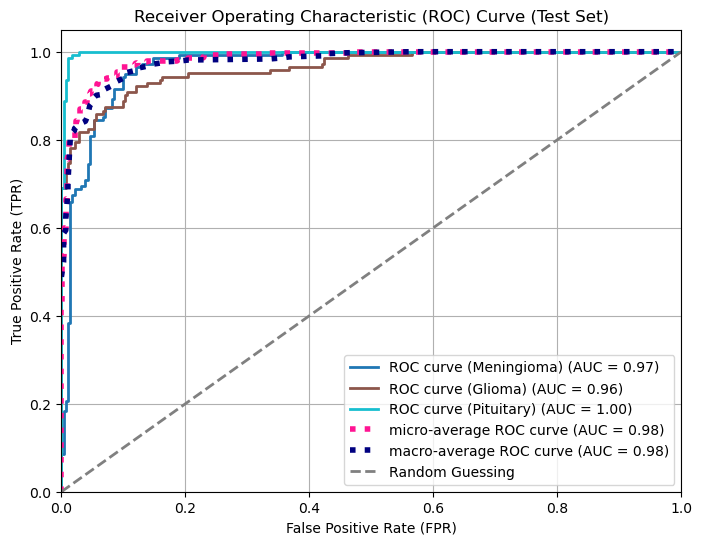

In [31]:
final_svm_model = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
final_svm_model.fit(X_train.reshape(len(X_train), -1), y_train)

# Obtain predicted probabilities for each class on the test set
y_test_prob = final_svm_model.predict_proba(X_test.reshape(len(X_test), -1))

# Binarize the labels for roc_curve
n_classes = len(np.unique(y_test))
class_names = ['Meningioma', 'Glioma', 'Pituitary']  # Updated class names
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])  # Use one-vs-all ROC
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_test_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
roc_auc_macro = auc(all_fpr, mean_tpr)

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
colors = plt.cm.tab10(np.linspace(0, 1, n_classes))  # Get an array of colors from 'tab10' colormap
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve ({class_names[i]}) (AUC = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, linestyle=':', color='deeppink', lw=4,
         label=f'micro-average ROC curve (AUC = {roc_auc_micro:.2f})')

# Plot macro-average ROC curve
plt.plot(all_fpr, mean_tpr, linestyle=':', color='navy', lw=4,
         label=f'macro-average ROC curve (AUC = {roc_auc_macro:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#code referencd: https://www.kaggle.com/code/ashfakyeafi/brain-tumor-type-classification/notebook





## Visualize Final result

Accuracy on test set: 0.83
              precision    recall  f1-score   support

           1       0.74      0.84      0.78       141
           2       0.91      0.68      0.78       142
           3       0.87      0.97      0.92       142

    accuracy                           0.83       425
   macro avg       0.84      0.83      0.83       425
weighted avg       0.84      0.83      0.83       425



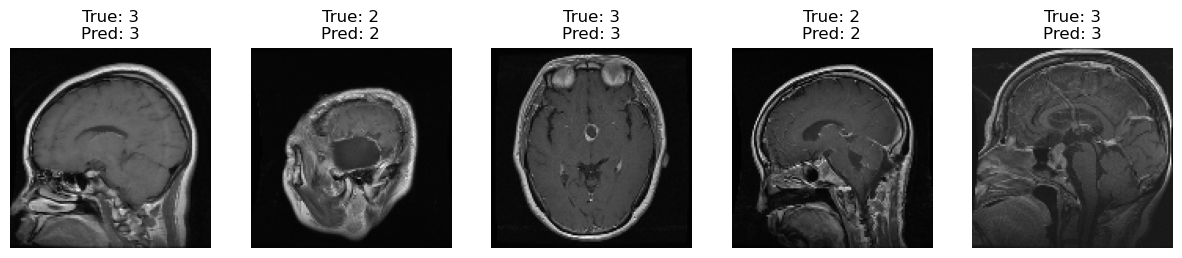

In [36]:
#images_train, masks_train, labels_train, images_val, masks_val, labels_val, images_test, masks_test, labels_test = split_data(images, masks, labels, test_size=0.2, val_size=0.25)

# Reshape images into feature vectors
num_train_samples = images_train.shape[0]
num_test_samples = images_test.shape[0]
feature_size = np.prod(images_train.shape[1:])  # Calculate the total number of pixels (features) per image

X_train = images_train.reshape(num_train_samples, feature_size)
X_test = images_test.reshape(num_test_samples, feature_size)

# Initialize and train SVM classifier
svm_classifier = SVC(kernel='rbf', random_state=42)
svm_classifier.fit(X_train, labels_train)

# Make predictions on the test set
predicted_labels = svm_classifier.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(labels_test, predicted_labels)
print(f"Accuracy on test set: {accuracy:.2f}")

# Display classification report
print(classification_report(labels_test, predicted_labels))

# Visualize results 
def visualize_results(images, labels, predicted_labels, num_samples=5):
    indices = np.random.choice(len(images), num_samples, replace=False)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[idx], cmap='gray')
        title = f"True: {labels[idx]}\nPred: {predicted_labels[idx]}"
        plt.title(title)
        plt.axis('off')
    plt.show()

# Visualize some sample predictions for visual check
visualize_results(images_test, labels_test, predicted_labels)


# PART VI: BENCHMARKING THE DATASET

In [37]:
# Define input directory for preprocessing
benchmark_data_dir = 'C:/Users/embilab/OneDrive - Emory University/Spring 2024/CS - 534 Machine Learning/Machine Learning Project/Benchmark/All Together'

# Specify desired image dimensions for preprocessing
image_dimension = 128

# Preprocess the generated .mat files
images, masks, labels = load_and_preprocess_data(benchmark_data_dir, image_dimension)


Total files found: 1649
[1640/1649] images loaded: 99.5 %
Finished loading and processing data. Successfully processed 1649/1649 files.


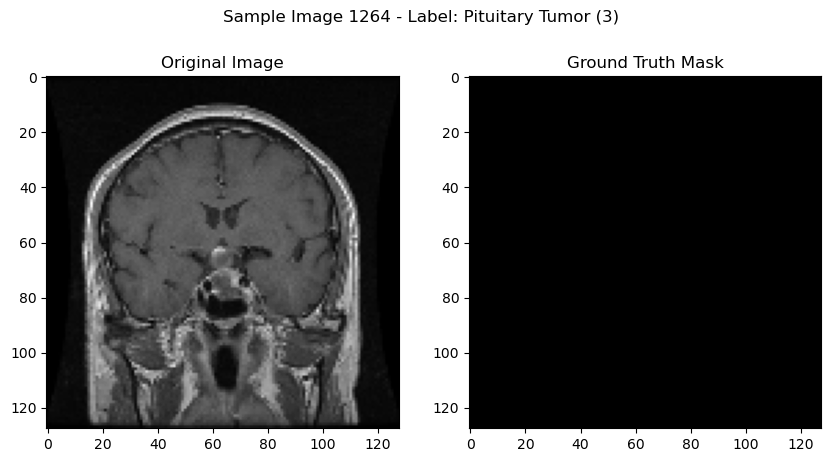

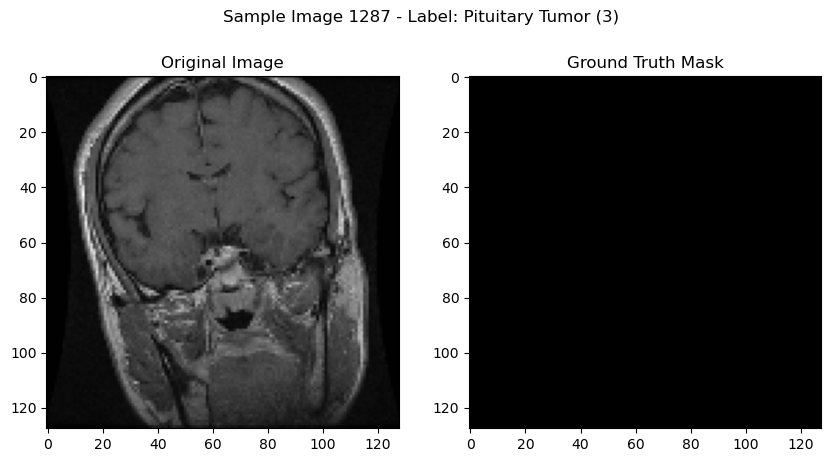

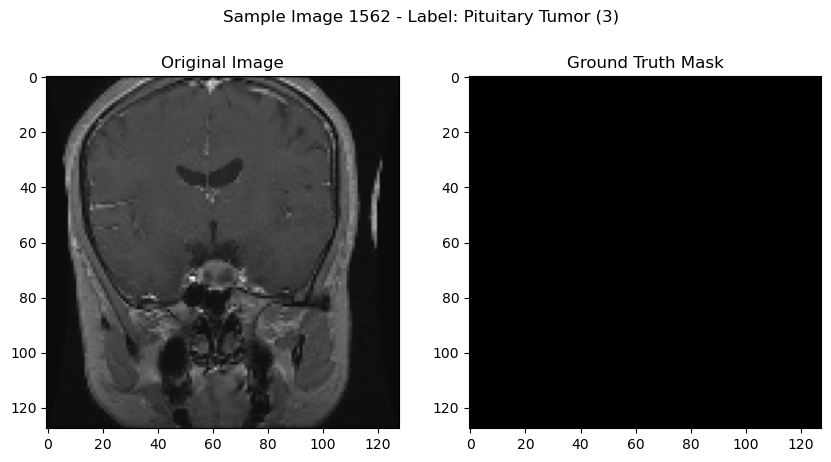

In [38]:
#Visualize sample

visualize_sample_images(images, masks, labels, num_samples=3)

In [47]:
# Trim y_train to match x_train
y_train_trimmed = y_train[:X_train.shape[0]]

# Reshape x_train for SVM input if necessary
X_train_flattened = X_train.reshape(len(X_train), -1)


# Print shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


# Initialize SVM model with rbf kernel
svm_model = SVC(kernel='rbf', C=1.0, random_state=42)

try:
    # Fit the SVM model
    svm_model.fit(X_train_flattened, y_train_trimmed)
    
    flattened_images = images.reshape(len(images), -1)
    benchmark_predictions = svm_model.predict(flattened_images)

    # Evaluate the model's performance
    benchmark_accuracy = accuracy_score(labels, benchmark_predictions)
    benchmark_precision = precision_score(labels, benchmark_predictions, average='weighted')
    benchmark_recall = recall_score(labels, benchmark_predictions, average='weighted')
    benchmark_f1 = f1_score(labels, benchmark_predictions, average='weighted')
    benchmark_jaccard = jaccard_score(labels, benchmark_predictions, average='weighted')
    benchmark_dice = fbeta_score(labels, benchmark_predictions, beta=1, average='weighted')

    # Compute confusion matrix
    benchmark_conf_matrix = confusion_matrix(labels, benchmark_predictions)

    # Display evaluation metrics
    print(f"Benchmark Accuracy: {benchmark_accuracy:.4f}")
    print(f"Benchmark Precision: {benchmark_precision:.4f}")
    print(f"Benchmark Recall: {benchmark_recall:.4f}")
    print(f"Benchmark F1 Score: {benchmark_f1:.4f}")
    print(f"Benchmark Jaccard Index: {benchmark_jaccard:.4f}")
    print(f"Benchmark Dice Similarity: {benchmark_dice:.4f}")
    print("Confusion Matrix:\n", benchmark_conf_matrix)

except ValueError as e:
    print(f"Error occurred during model fitting or evaluation: {e}")



X_train shape: (1168, 16384)
y_train shape: (1700,)
Benchmark Accuracy: 0.0000
Benchmark Precision: 0.0000
Benchmark Recall: 0.0000
Benchmark F1 Score: 0.0000
Benchmark Jaccard Index: 0.0000
Benchmark Dice Similarity: 0.0000
Confusion Matrix:
 [[  0 822   0]
 [  0   0   0]
 [  0 827   0]]


C:\Users\embilab\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\embilab\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
